In [75]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams


import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.graph_objects as go
import plotly.express as px

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
indir = "../../data/3bulk/"
cell_types = ["0", "1", "2"]

In [77]:
reference_file = os.path.join(indir, "sc.tsv")
reference_mdata_file = os.path.join(indir, "pdata.tsv")
bulk_file = os.path.join(indir, "bulk.tsv")

true_df = pd.read_csv(os.path.join(indir, "proportions.csv"), sep=",", index_col=0)
# true_df = true_df.reindex(sorted(true_df.columns), axis=1)

sadata = dv.tl.read_data(reference_file)
pheno_df = pd.read_csv(reference_mdata_file, sep="\t", index_col=0)
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))

sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs["labels"] = pheno_df["cellType"].values
sadata.obs["labels"] = sadata.obs["labels"].astype("category")
sadata = sadata[sadata.obs["labels"].astype("str").isin(cell_types), :].copy()
sadata.obs["labels"] = sadata.obs["labels"].cat.rename_categories(["MDA-MB-438", "MCF7", "HF"])

print(sadata.obs.groupby("labels").size())

bulk_df = pd.read_csv(bulk_file, sep="\t", index_col=0)

print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
del sadata
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=False)
# sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)

labels
MDA-MB-438    1988
MCF7           686
HF             319
dtype: int64
bulk RNA-seq data - samples: 1, genes: 58387
scRNA-seq data - cells: 2993, genes: 18597
bulk RNA-seq data - samples: 1, genes: 18597


In [78]:
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
# sc.settings.figdir = "../deconV/figures/"
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["cellType"], frameon=True, legend_loc="on data", save="_3_bulk.pdf", title="")

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [85]:
decon = dv.DeconV(
    adata, cell_type_key="labels",
    dropout_type="separate",
    model_type="beta", sub_type_key=None,
    device=device
)

In [86]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts", fp_hack=True)

100%|██████████| 2000/2000 [05:11<00:00,  6.43it/s, loss=1.21e+04, lr=1.35e-02]


In [87]:
# decon.check_fit()

In [88]:
proportions = decon.deconvolute(model_dropout=False, lrd=0.999, lr=0.1, num_epochs=1000, progress=True)
proportions

100%|██████████| 1000/1000 [00:05<00:00, 199.24it/s, loss=1.79e+08, lr=3.68e-02]


tensor([[0.1111, 0.0217, 0.8672]], device='cuda:0', dtype=torch.float64)

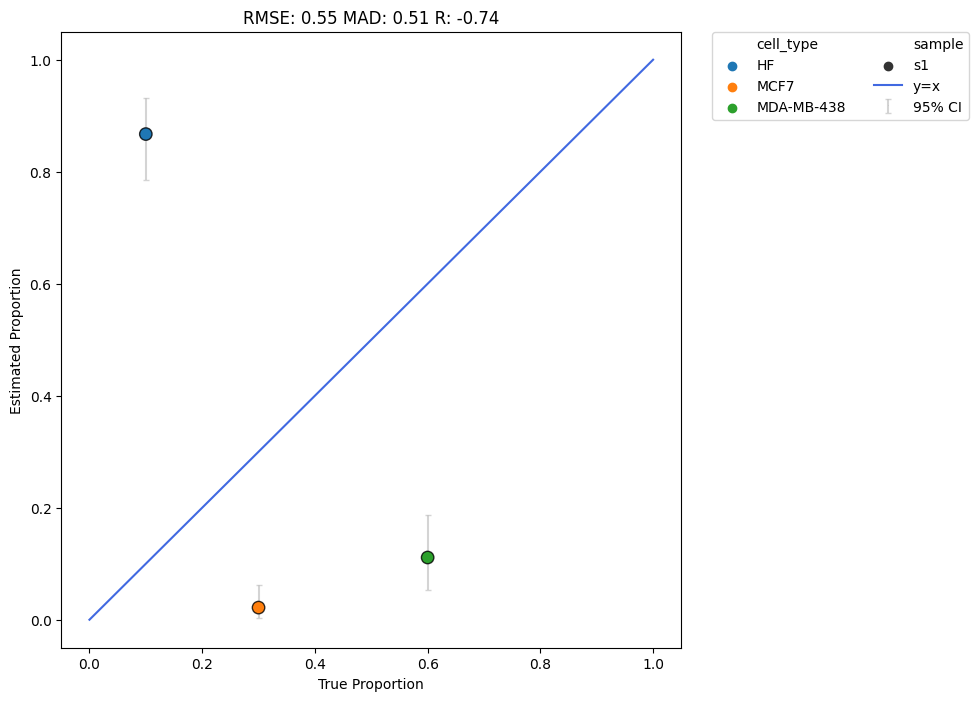

(0.5492843276514388, 0.5114886531562626, -0.741853181627125)

In [89]:
res_df = decon.get_results_df().sort_values(["cell_type", "sample"])
res_df["true"] = true_df.reset_index().melt(id_vars="index").sort_values(["variable", "index"])["value"].values
dv.pl.xypredictions(res_df)